In [1]:
# To ignore future warnings
import warnings
warnings.filterwarnings('ignore')

# Install the library used for calculating LRP
# % pip install innvestigate

import innvestigate
import innvestigate.utils as iutils

Using TensorFlow backend.


In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import numpy as np
import pandas as pd


import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Conv2D
import keras.backend
import keras.layers
import keras.models
import keras.utils
from sklearn.metrics import roc_curve, auc, confusion_matrix


import matplotlib.pyplot as plt
plt.style.use('ggplot')


# Train and evaluate a 2D CNN model to classify Iris flowers using Keras

In [3]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# One hot encoding for class names
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Normalize the attributes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=42)

# Reshape the data for a 2D convolutional neural network
X_train = X_train.reshape(75, 2, 2, 1)
X_test = X_test.reshape(75, 2, 2, 1)

n_features = X.shape[1]
n_classes = Y.shape[1]

In [4]:
# Define the model
model = None
model = keras.Sequential()

model.add(Conv2D(32, (1,1), activation='relu', input_shape=(2,2,1)))
model.add(Flatten())

model.add(Dense(3, input_dim = n_classes, activation='softmax'))  

# Compile
model.compile (loss="categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

# Train
history_callback = model.fit (X_train, Y_train, epochs = 50, batch_size = 5,
           validation_data=(X_test, Y_test),
           verbose = 0)

scores = model.evaluate(X_test, Y_test, verbose=0)

# Evaluate the model's performance:
print('Test log loss:', scores[0])
print('Test accuracy:', scores[1])

W0905 18:32:07.445701 140286380676736 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 18:32:07.460232 140286380676736 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 18:32:07.463173 140286380676736 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0905 18:32:07.520013 140286380676736 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0905 18:32:07.550639 140286380676736 deprecation_wrapper.py:119] From /usr/lib/

Test log loss: 0.10767801950375239
Test accuracy: 0.9866666666666667


In [5]:
CNN_X_test_predictions = model.predict_classes(X_test)

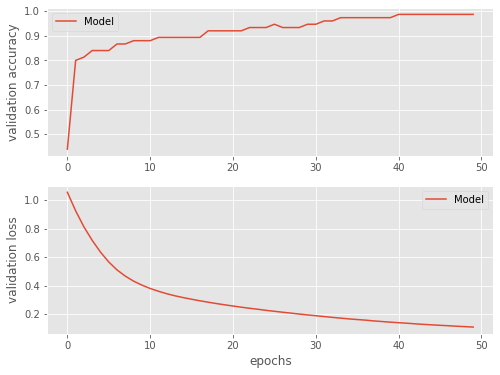

In [6]:
# Plot the accuracy
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

val_acc = history_callback.history['val_acc']
val_loss = history_callback.history['val_loss']
ax1.plot(val_acc, label="Model")
ax2.plot(val_loss, label="Model")
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()

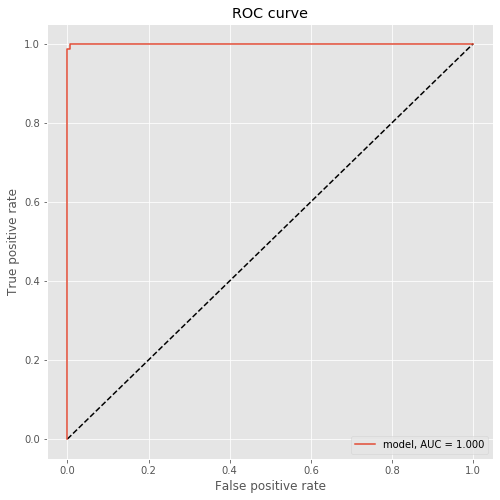

In [7]:
# Plot the ROC
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
    
Y_pred = model.predict(X_test)
fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())

plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format("model", auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [8]:
# To create the confusion matrix
real = np.argmax(Y_test, axis=1)
pred = np.argmax(Y_pred, axis=1)
confusion = pd.crosstab(real, pred)
confusion

col_0,0,1,2
row_0,,,
0,29,0,0
1,0,23,0
2,0,1,22


# Calculate the Layerwise Relevance Propagation for the 2D model

In [9]:
# Function to output innvestigate's LRP "Alphabeta value": 
# (for other options, see 
# https://github.com/albermax/innvestigate/blob/accbb99d0da2eb47f22e3d04563c8964e2b1ad90/innvestigate/analyzer/relevance_based/relevance_analyzer.py)
# lines 36-65

def deeptaylor (instance, dataframe):
    # Stripping the softmax activation from the model
    model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

    # Creating an analyzer
    #gradient_analyzer = innvestigate.create_analyzer("lrp.alpha_2_beta_1", model_wo_sm)
    analyzer = innvestigate.create_analyzer("deep_taylor", model_wo_sm)

    # Applying the analyzer (reshape the instance for the LRP function)
    analysis = analyzer.analyze(np.expand_dims(dataframe[instance], axis=0))
    lst = []
    x = np.reshape (analysis,(4,))
    for i in range (len(x)):
      lst.append(x[i])
    return lst

In [10]:
# Choose an instance to test:
example = 74
example = X_train[example]

model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("deep_taylor", model_wo_sm)

# Applying the analyzer
analysis = gradient_analyzer.analyze(np.expand_dims(example, axis=0))

print (analysis)

[[[[0.46830595]
   [0.02456851]]

  [[1.1800829 ]
   [1.257865  ]]]]


In [11]:
# Create and save two dataframes (train and test) containing Alphabeta LRP information obtained from the 2D CNN:
def create_lrp_dataframe(train_df, train_label):
    df = pd.DataFrame(columns=list(iris.feature_names))
    for i in range(len(train_df)):
      df.loc[i] = deeptaylor(i, train_df)

    lst = []
    for i in train_label:
      lst.append (i.argmax(axis = 0))
    lst = pd.Series (lst)
    df['target'] =  lst
    
    return df

In [12]:
# Save the LRP dataframes as pickle objects

iris_train_LRP = create_lrp_dataframe(X_train, Y_train)
iris_test_LRP = create_lrp_dataframe(X_test, Y_test)

iris_train_LRP.to_pickle("iris_train_LRP_pickle.pkl")
iris_test_LRP.to_pickle("iris_test_LRP_pickle.pkl")

In [13]:
# Read from the pickle file in future:
iris_test_LRP = pd.read_pickle('/home/shayan/Desktop/code/lrp/lrp/code/iris_test_LRP_pickle.pkl')

# Develop a kNN model to classify the Iris flowers

In [14]:
iris = load_iris()
X = iris['data']
y = iris['target']

# Normalize the attributes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, y, test_size=0.5, random_state=42)

In [15]:
# Create an array in a shape that can be used in the kNN model:
# example instance:
# [-0.9006811702978099, 1.7095946507475455, -1.2833890997091604, -1.18381211071744, 0]
def create_iris_array(train_arry, test_arry):
    iris = []
    for i in range(len(train_arry)):
        elem = list(train_arry[i])
        elem.append(test_arry[i])
        iris.append(elem)
    return iris

iris_train = create_iris_array(X_train, Y_train)
iris_test = create_iris_array(X_test, Y_test)

# To test the above function:
z = 14
print (iris_test[z],X_test[z],Y_test[z])

[-0.9006811702978099, 1.7095946507475455, -1.2833890997091604, -1.18381211071744, 0] [-0.90068117  1.70959465 -1.2833891  -1.18381211] 0


In [16]:
# Create an array that combines the test data set with LRP values:
# [[attribute's LRP,attribute],...,class]

iris_test_LRP_array = iris_test_LRP.values.tolist()
_1 = iris_test_LRP_array[0]
_2 = iris_test[0]

new_list=[]
for i in range (len(_1)-1):
    lst=[]
    lst.append(_1[i])
    lst.append(_2[i])
    new_list.append(lst)
if _1[-1] == float(_2[-1]):
    new_list.append(_2[-1])
print (new_list)

[[0.11423216015100479, 0.310997534138703], [0.12780781090259552, -0.5923730118389191], [0.0707712471485138, 0.5354085615261401], [5.92577998759225e-05, 0.0008775478952676988], 1]


In [17]:
# Above cell was perfomed on one instance. Let's perform it for the whole test array:

iris_test_plus_LRP=[]
for j in range(len(iris_test_LRP_array)):
    _1 = iris_test_LRP_array[j]
    _2 = iris_test[j]
    new_list=[]
    for i in range (len(_1)-1):
        lst=[]
        lst.append(_1[i])
        lst.append(_2[i])
        new_list.append(lst)
    if _1[-1] == float(_2[-1]):
        new_list.append(_2[-1])
    iris_test_plus_LRP.append (new_list)

In [18]:
# test and compare the newly combined array with test and LRP arrays respectively:
iris_test_plus_LRP[40]

[[0.002339934231713414, -0.052506077192250644],
 [0.11202909797430038, -0.8225697780975647],
 [0.540917694568634, 0.7627582691805523],
 [0.7159241437911987, 0.9223028379273737],
 2]

In [19]:
iris_test_LRP_array[40]

[0.002339934231713414,
 0.11202909797430038,
 0.540917694568634,
 0.7159241437911987,
 2.0]

In [20]:
iris_test[40]

[-0.052506077192250644,
 -0.8225697780975647,
 0.7627582691805523,
 0.9223028379273737,
 2]

In [21]:
# Create a kNN model:
# adopted from https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/

import random
import math
import operator

# We won't use this split function because we want our split fraction to be consistent with that of our Keras model.
# def loadDataset(filename, split, trainingSet=[] , testSet=[]):
# 	with open(filename, 'r') as csvfile:
# 	    lines = csv.reader(csvfile)
# 	    dataset = list(lines)
# 	    for x in range(len(dataset)-1):
# 	        for y in range(4):
# 	            dataset[x][y] = float(dataset[x][y])
# 	        if random.random() < split:
# 	            trainingSet.append(dataset[x])
# 	        else:
# 	            testSet.append(dataset[x])

def euclideanDistance(instance1, instance2, length):
	distance = 0
	for x in range(length):
# 		distance += pow((instance1[x] - instance2[x]), 2)
# Modify the Euclidean distance formula to add the LRP as a factor
# instance1[x][0] is the LRP value of instance1[x][1]
		distance +=  instance1[x][0]*(pow((instance1[x][1] - instance2[x]), 2))
	return math.sqrt(distance)

# Find the nearest neighbors
def getNeighbors(trainingSet, testInstance, k):
	distances = []
	length = len(testInstance)-1
	for x in range(len(trainingSet)):
		dist = euclideanDistance(testInstance, trainingSet[x], length)
		distances.append((trainingSet[x], dist))
	distances.sort(key=operator.itemgetter(1))
	neighbors = []
	for x in range(k):
		neighbors.append(distances[x][0])
	return neighbors

# Determine the class with the majority vote
def getResponse(neighbors):
	classVotes = {}
	for x in range(len(neighbors)):
		response = neighbors[x][-1]
		if response in classVotes:
			classVotes[response] += 1
		else:
			classVotes[response] = 1
	sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
	return sortedVotes[0][0]

# Determine the accuracy of the kNN model
def getAccuracy(testSet, predictions):
	correct = 0
	for x in range(len(testSet)):
		if testSet[x][-1] == predictions[x]:
			correct += 1
	return (correct/float(len(testSet))) * 100.0

# Create confusion matrix
def create_confusion(true_class, predicted_class):
		real=[]
		for i in true_class:
			real.append(i[-1])
		print (confusion_matrix(real, predicted_class))

# Run all of the above functions
def main():
	# prepare data
	trainingSet=iris_train #[]
# 	testSet=iris_test #[]
	testSet=iris_test_plus_LRP #[]
# 	split = 0.67
# 	loadDataset('iris.data', split, trainingSet, testSet)
	print ('Train set: ' + repr(len(trainingSet)))
	print ('Test set: ' + repr(len(testSet)))
	# generate predictions
	predictions=[]
	k = 3
	for x in range(len(testSet)):
		neighbors = getNeighbors(trainingSet, testSet[x], k)
		result = getResponse(neighbors)
		predictions.append(result)
# 		print('> predicted=' + repr(result) + ', actual=' + repr(testSet[x][-1]))
	accuracy = getAccuracy(testSet, predictions)
	print('Accuracy: ' + repr(accuracy) + '%')
	create_confusion(testSet,predictions)
	return predictions

In [22]:
kNN_X_test_predictions = main()

Train set: 75
Test set: 75
Accuracy: 100.0%
[[29  0  0]
 [ 0 23  0]
 [ 0  0 23]]


In [23]:
# test the modified Euclidean formula above:
def euclideanDistance(instance1, instance2, length):
	distance = 0
	for x in range(length):
# 		distance += pow((instance1[x] - instance2[x]), 2)
		distance +=  instance1[x][0]*(pow((instance1[x][1] - instance2[x]), 2))
	return (math.sqrt(distance))

# print (iris_test_plus_LRP[0], "\n")
# print(iris_test_plus_LRP[0], "\n")

a= 0.1573006957769394 * (pow((0.310997534138703--0.5371775589668552),2))
b= 0.22285720705986023 * (pow((-0.5923730118389191--0.1319794793216258),2))
c= 0.09518780559301376 * (pow((0.5354085615261401-0.42173370769893376),2))
d= 0.0001663241273490712 * (pow((0.0008775478952676988-0.3957741007661703),2))

assert(math.sqrt(a+b+c+d),euclideanDistance(iris_test_plus_LRP[0], iris_train[0], 4)) # passes

In [24]:
def if_matches(x,y):
    if x==y:
        return 1
    else:
        return 0

In [25]:
matches = list(map(if_matches,CNN_X_test_predictions, kNN_X_test_predictions))

In [26]:
# The percentage of the CNN predictions that match those of the kNN model.
print (matches.count(1)/len(matches)*100)

98.66666666666667
